<a href="https://colab.research.google.com/github/Ayoyinka-Sofuwa/Fastai-projects/blob/main/FastAi_tutorial_practise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastai

In [3]:
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 9.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [4]:
from fastai import *

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
  print(f"searching for {term}")
  return L(ddg_images(term, max_results = max_images)).itemgot("image")

Let's start by searching for a cat photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [6]:
urls = search_images("cat photos", max_images=1)
urls[0]

searching for cat photos


'https://viralcats.net/blog/wp-content/uploads/2020/02/Relaxed-by-Ionut-Donici.jpg'

and then we download a URL and take a look at it:

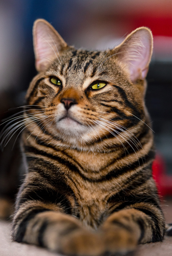

In [7]:
from fastdownload import download_url
from fastai.vision.all import *

desc = "cat.jpg"
download_url(urls[0], desc, show_progress=True)

im = Image.open(desc)
im.to_thumb(256,256)

Now let's do the same with "dog photos":

searching for dog photos


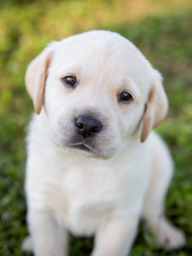

In [8]:
# more concise code of the code used to download the cat image
download_url(search_images("dog photos", max_images=1)[0], "dogs.jpg", show_progress=False)

Image.open("dogs.jpg").to_thumb(256, 256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "cat" and "dog" photos, and save each group of photos to a different folder (I'm also trying to grab a range of different conditions here):

In [9]:
searches = 'dog','cat'
path = Path('cat_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  
    # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} outdoor photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} indoor photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

searching for dog photo
searching for dog outdoor photo
searching for dog indoor photo
searching for cat photo
searching for cat outdoor photo
searching for cat indoor photo


#### Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:
failed = verify_images(get_image_files(path))
print(failed)
failed.map(Path.unlink)
len(failed)

[Path('cat_or_not/dog/f819e185-5344-4667-b32c-180be1dd5641.jpg'), Path('cat_or_not/dog/2865d083-466a-4074-a8d0-cd6bd09b89fc.jpg')]


2

Five of our images are broken

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

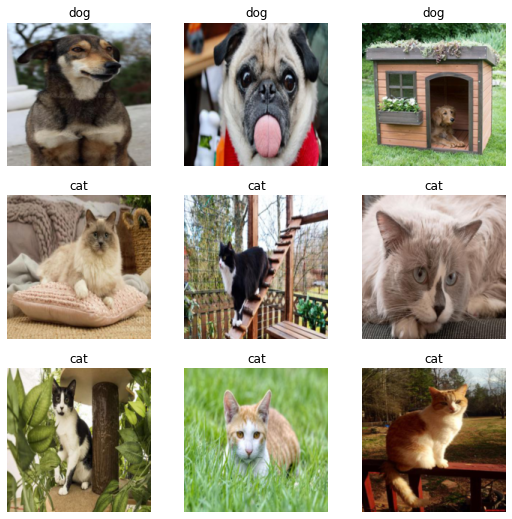

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #validation is 20%
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')] #squish or crop
    ).dataloaders(path, bs=32)

dls.show_batch(max_n=9)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 
2
To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label, dest path created in loop used to find all the data online

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *cat* or *dog*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate) #learner, model and evaluation metric

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.689756,0.789739,0.272727,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.456059,0.364341,0.212121,00:02
1,0.293910,0.123662,0.030303,00:01
2,0.193953,0.110770,0.030303,00:01
3,0.151965,0.105718,0.030303,00:01
4,0.123414,0.110847,0.030303,00:01


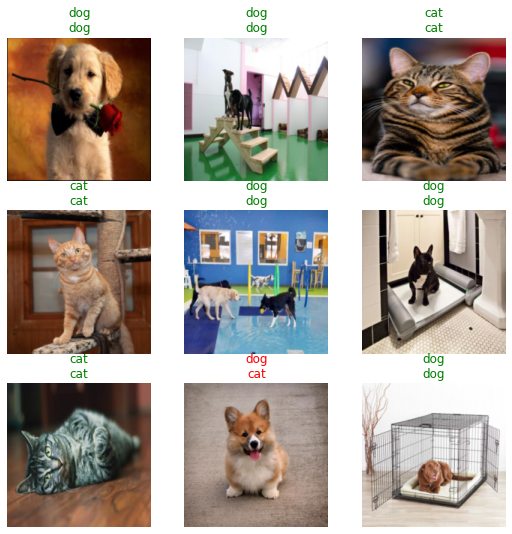

In [18]:
learn.show_results()

In [14]:
learn1 = vision_learner(dls, resnet34, metrics=error_rate)
learn1.fine_tune(5)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.009774,0.139080,0.090909,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.315010,0.120798,0.030303,00:01
1,0.192468,0.100240,0.030303,00:01
2,0.152271,0.039748,0.000000,00:01
3,0.116646,0.031206,0.000000,00:01
4,0.097258,0.035425,0.000000,00:01


**Loss and error rate is minimized for each model after each layer is run.**

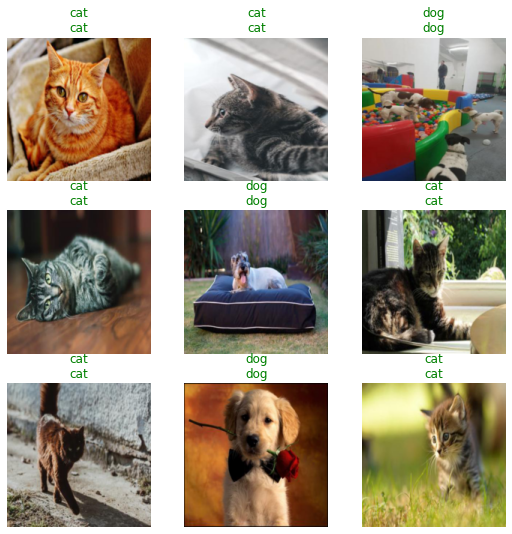

In [21]:
learn1.show_results()

In [15]:
is_cat,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")

This is a: cat.
Probability it's a cat: 0.9999


This shows that our model almost accurately predicts that our image is a cat

In [16]:
is_cat,_,probs = learn1.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")

This is a: cat.
Probability it's a cat: 1.0000


Our model accurately predicts it's a cat. Resnet34 performs better than Resnet18